# 09 图像噪声

假设原图函数是 $f$, 加入噪声可以近似视为一个卷积噪声与一个噪声项的和:
$$g(x,y) = h(x,y)*f(x,y) +\eta (x,y)$$


## 噪声

为了简单，先不考虑卷积项 $h$, (即设它为恒等算子) 即
$$g(x,y) = f(x,y)+\eta(x,y)$$ 

$\eta(x,y):\ \mathbb Z^2\rightarrow \mathbb R$ 可以是独立同分布的随机变量, 如高斯噪声、均值噪声......

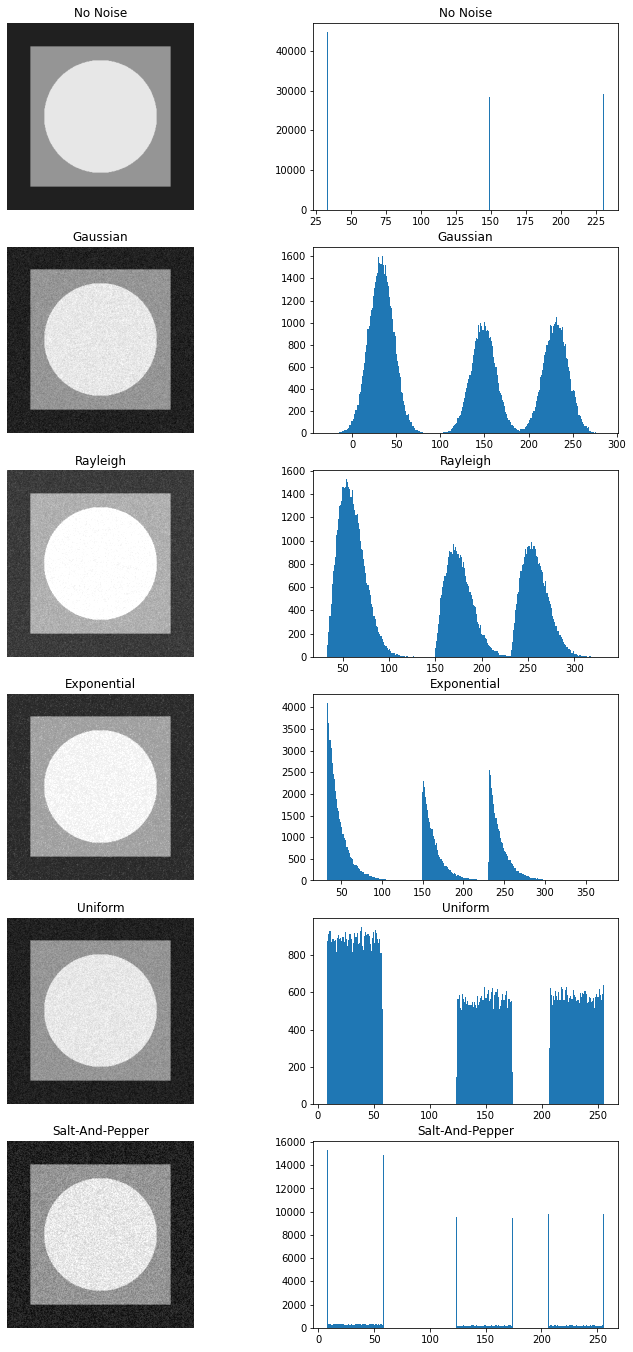

In [38]:
from matplotlib import pyplot as plt
import numpy as np

N = 320
img = np.full((N,N), 33)
img[N//8:-N//8, N//8:-N//8] = 149
coor = np.meshgrid(np.arange(N), np.arange(N))
coor = (coor[0] - coor[0].mean(), coor[1] - coor[1].mean())
img = np.where(coor[0]**2+coor[1]**2 < N*N/11, 231, img)

svar = 200 ** .5
noises = {
    'No Noise': lambda x: 0,
    'Gaussian': lambda x: np.random.randn(*x.shape) * svar,
    'Rayleigh': lambda x: np.random.rayleigh(size = x.shape) * ((2. / (4 - np.pi)) ** .5 * svar),
    'Exponential': lambda x: np.random.exponential(size = x.shape) * svar,
    'Uniform': lambda x: ((np.random.random(x.shape) - .5) * (svar * 12 ** .5)),
    'Salt-And-Pepper': lambda x: np.where(np.random.randint(0, 3, size = x.shape) != 0,\
        np.where(np.random.randint(0, 2, size = x.shape) == 1, 25, -25),
        ((np.random.random(x.shape) - .5) * (svar * 12 ** .5)))
}

plt.figure(figsize = (12, 24))
for i, (name, noise) in enumerate(noises.items()):
    plt.subplot(len(noises), 2, 2*i + 1)
    img2 = img + noise(img)
    plt.imshow(img2, cmap = 'gray', vmin = 0, vmax = 255)
    plt.title(name)
    plt.axis('off')
    plt.subplot(len(noises), 2, 2*i + 2)
    plt.hist((img2.flatten()), bins = 255)
    plt.title(name)
plt.show()

## 去噪

### 均值滤波器

假设不考虑卷积项, $g(x,y) = f(x,y)+\eta(x,y)$, 其中 $f$ 为原图, $\eta $ 为噪声. 若使用均值滤波器作用于 $g$, 如
$$\bar g = \frac 19\sum_{i=-1}^1\sum_{j=-1}^1 \left(f(x+i,y+j)+\eta (x+i,y+j)\right) = \bar f + \bar \eta$$

若 $\eta(x,y)$ 是期望为零且独立同分布的, 则取均值后 $\bar \eta$ 期望为零, 方差减小, 从而 $\bar\eta$ 更可能接近零, 达到去噪的目的.

除了算术平均以外, 也可以用几何平均、调和平均(谐波均值滤波器)等等. 


### 统计排序滤波器

除了均值以外, 还能取中值滤波器 (中位数), 最大值或最小值等等.

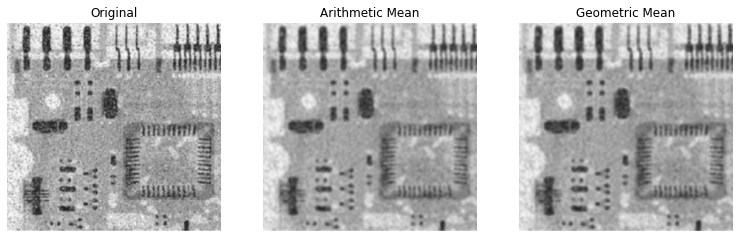

In [73]:
import os
from matplotlib import pyplot as plt
from PIL import Image 
import numpy as np 

def ArithmeticMean(img, N = 7):
    from numba import stencil
    @stencil(neighborhood = ((-(N//2),(N//2)),(-(N//2),(N//2)),))
    def AverageConv(img):
        return img[-(N//2):(N//2)+1,-(N//2):(N//2)+1].mean()
    return AverageConv(np.pad(img, N//2, mode='edge'))[N//2:-(N//2), N//2:-(N//2)]

def GeometricMean(img, N = 7):
    return np.exp(ArithmeticMean(np.log(img + 1e-14), N = N)).astype(img.dtype)

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\chip.png')).convert('L'))
plt.figure(figsize = (13, 4))
for i, (name, func) in enumerate(
    {'Original': lambda x: x, 'Arithmetic Mean': ArithmeticMean, 'Geometric Mean': GeometricMean}.items()):
    plt.subplot(1,3,i+1)
    plt.imshow(func(img), cmap = 'gray', vmin = 0, vmax = 255)
    plt.title(name)
    plt.axis('off')
plt.show()

### 带阻滤波器

在频率域, 确定 $r,z_0$ 后乘上如下高斯带阻滤波器, 则模长接近 $|z_0|$ 的频段被滤去. 

此外, 下式指数分母中的 |z| 可以防止原点处的低频信息被滤去.
$$H(z) = 1 -e^{-\left(\frac{|z|^2-|z_0|^2}{|z|r}\right)^2}$$


<br>

类似的带阻滤波器 (band reject filter) 有布特沃斯带阻滤波器.

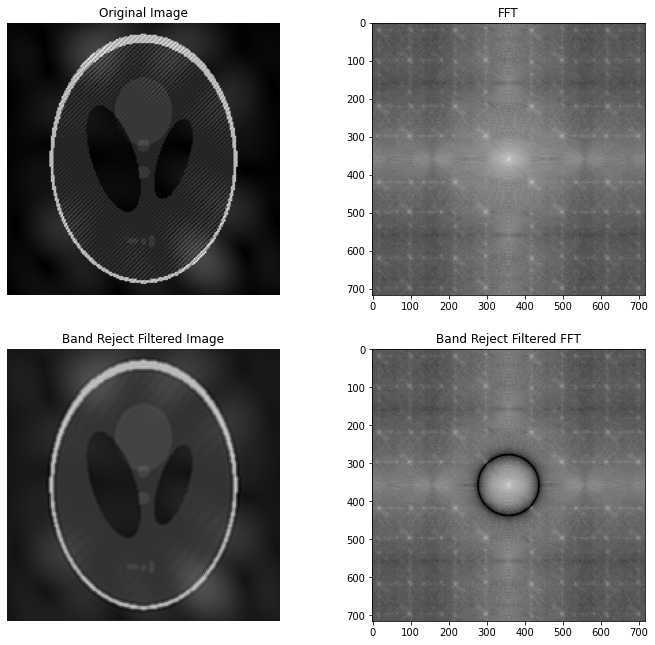

In [109]:
import os
from matplotlib import pyplot as plt
from PIL import Image 
import numpy as np 
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\CT.png')).convert('L'))
img_fft = np.fft.fftshift(np.fft.fft2(img))
vmin, vmax = np.log(np.abs(img_fft) + 1e-14).min(), np.log(np.abs(img_fft) + 1e-14).max()

coor = np.meshgrid(np.linspace(-1,1,img.shape[1]), np.linspace(-1,1,img.shape[0]))
gauss_br = 1. - np.exp(-(coor[0]**2+coor[1]**2-0.05)**2/(coor[0]**2+coor[1]**2)*20)
img_fft_filter = img_fft * gauss_br

img_filter = np.fft.ifft2(np.fft.ifftshift(img_fft_filter)).real


plt.figure(figsize = (12, 11))
plt.subplot(2,2,1)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.log(np.abs(img_fft) + 1e-14), cmap = 'gray')
plt.title('FFT')
plt.subplot(2,2,3)
plt.imshow(img_filter, cmap = 'gray')
plt.title('Band Reject Filtered Image')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.log(np.abs(img_fft_filter) + 1e-14), cmap = 'gray', vmin = vmin, vmax = vmax)
plt.title('Band Reject Filtered FFT')
plt.show()

### 陷波滤波器

频域上将两个关于原点对称的高通滤波器相乘得到陷波滤波器 (notch reject filter). 例如高斯陷波滤波器:

$$H(z)= \left(1 - e^{-\frac{|z-z_0|^2}{2\sigma^2}}\right)\left(1 - e^{-\frac{|z+z_0|^2}{2\sigma^2}}\right)$$

将两个关于原点对称的相乘是为了保证它是共轭对称的! 这样子逆傅里叶后才会变成实数.

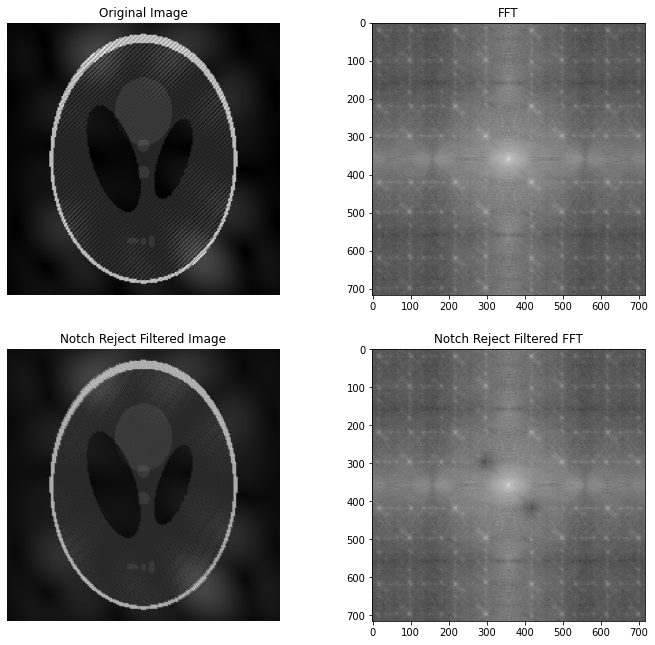

In [148]:
import os
from matplotlib import pyplot as plt
from PIL import Image 
import numpy as np 
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\CT.png')).convert('L'))
img_fft = np.fft.fftshift(np.fft.fft2(img))
vmin, vmax = np.log(np.abs(img_fft) + 1e-14).min(), np.log(np.abs(img_fft) + 1e-14).max()

coor = np.meshgrid(np.linspace(-1,1,img.shape[1]), np.linspace(-1,1,img.shape[0]))
zx, zy, var = .17, .17, 0.005
gauss_nr  = 1. - np.exp(-((coor[0]-zx)**2+(coor[1]-zy)**2)/(2*var))
gauss_nr *= 1. - np.exp(-((coor[0]+zx)**2+(coor[1]+zy)**2)/(2*var))
img_fft_filter = img_fft * gauss_nr

img_filter = np.fft.ifft2(np.fft.ifftshift(img_fft_filter)).real


plt.figure(figsize = (12, 11))
plt.subplot(2,2,1)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.log(np.abs(img_fft) + 1e-14), cmap = 'gray')
plt.title('FFT')
plt.subplot(2,2,3)
plt.imshow(img_filter, cmap = 'gray')
plt.title('Notch Reject Filtered Image')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.log(np.abs(img_fft_filter) + 1e-14), cmap = 'gray', vmin = vmin, vmax = vmax)
plt.title('Notch Reject Filtered FFT')
plt.show()

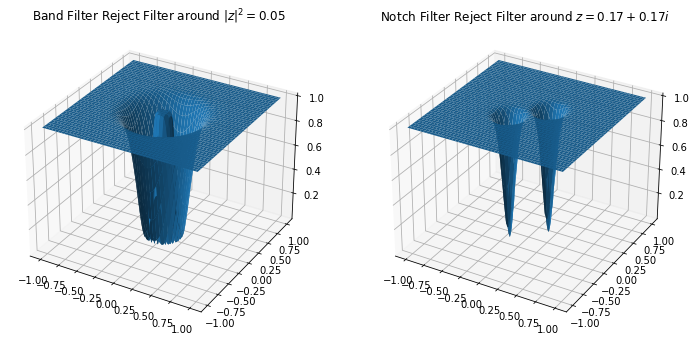

In [149]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6), subplot_kw = {'projection': '3d'})
for i, (func, name) in enumerate(zip((gauss_br, gauss_nr), 
        ('Band Filter Reject Filter around $|z|^2 = 0.05$', 
        'Notch Filter Reject Filter around $z=0.17+0.17i$'))):
    axes[i].plot_surface(coor[0], coor[1], func)
    axes[i].set_title(name)
plt.show()

### 最佳陷波滤波器

在时空域, 去噪可以看成将图片减掉噪声项: $f(x,y) = g(x,y)-\eta(x,y)$. 有时候可以在减掉的噪声项上乘上权重:
$$f(x,y) = g(x,y) - w(x,y)\eta(x,y)$$

若取 $w(x,y)$ 为如下定义式, 称为最佳陷波滤波器
$$w(x,y) = \frac{\overline{g(x,y)\cdot \eta(x,y)} - \overline{g(x,y)}\cdot \overline{\eta(x,y)}}{\overline{\eta^2}(x,y) - \overline{\eta (x,y)}^2}.$$

其中 $\bar g$ 表示邻域内的均值. 注意该式与最小二乘法形式相同.

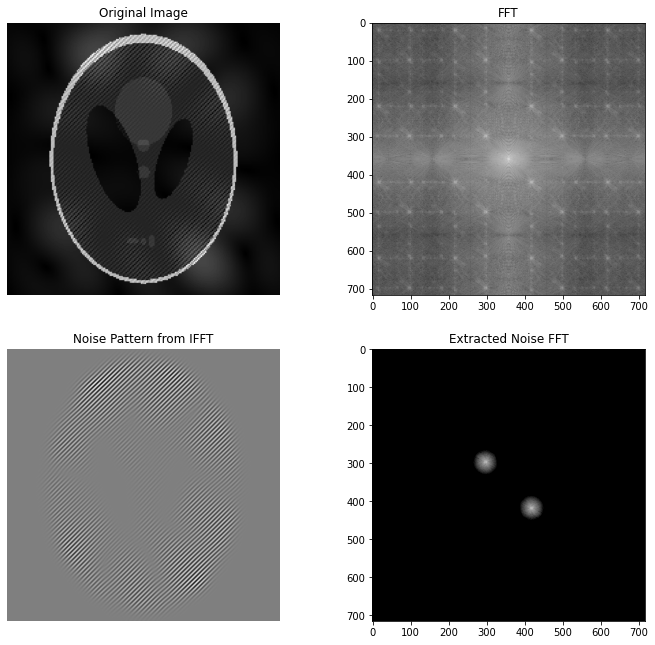

In [183]:
import os
from matplotlib import pyplot as plt
from PIL import Image 
import numpy as np 
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\CT.png')).convert('L'))
img_fft = np.fft.fftshift(np.fft.fft2(img))
vmin, vmax = np.log(np.abs(img_fft) + 1e-14).min(), np.log(np.abs(img_fft) + 1e-14).max()

coor = np.meshgrid(np.linspace(-1,1,img.shape[1]), np.linspace(-1,1,img.shape[0]))
zx, zy, var = .17, .17, 0.0005
gauss_nr  = 1. - np.exp(-((coor[0]-zx)**2+(coor[1]-zy)**2)/(2*var))
gauss_nr *= 1. - np.exp(-((coor[0]+zx)**2+(coor[1]+zy)**2)/(2*var))

# First extract the noise (eta) from frequency domain !!!
# Here we select out the two speckles in the frequency domain 
# and transform it back to spatial domain.
img_fft_noise = img_fft * (1. - gauss_nr)
img_noise = np.fft.ifft2(np.fft.ifftshift(img_fft_noise)).real


plt.figure(figsize = (12, 11))
plt.subplot(2,2,1)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.log(np.abs(img_fft) + 1e-14), cmap = 'gray')
plt.title('FFT')
plt.subplot(2,2,3)
plt.imshow(img_noise, cmap = 'gray')
plt.title('Noise Pattern from IFFT')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.log(np.abs(img_fft_noise) + 1e-14), cmap = 'gray', vmin = vmin, vmax = vmax)
plt.title('Extracted Noise FFT')
plt.show()

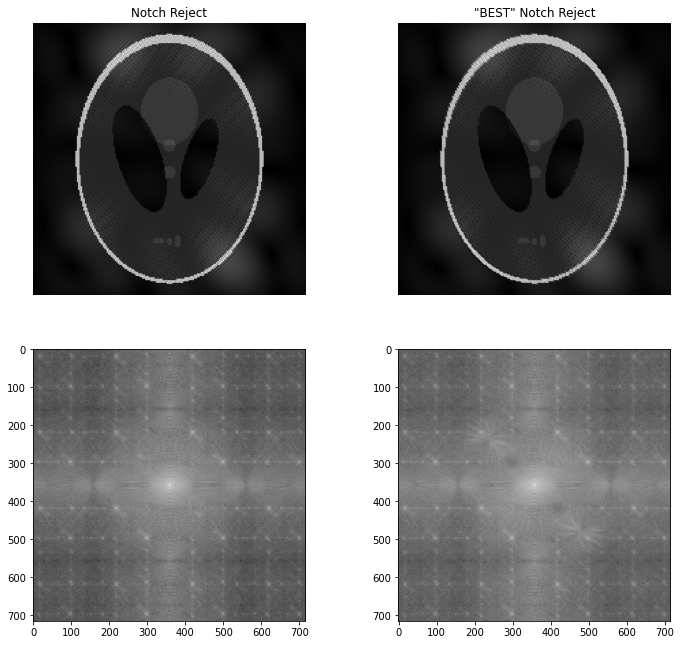

In [189]:
# Second compute the weights of noise
def Convolution(img, kernel, uint8 = False):
    img2 = np.zeros_like(img, dtype='float')
    img = np.pad(img, kernel.shape[0]//2, mode='edge').astype('float')
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            img2 += kernel[i,j] * img[kernel.shape[0]-1-i:kernel.shape[0]-1-i+img2.shape[0],
                                      kernel.shape[1]-1-j:kernel.shape[1]-1-j+img2.shape[1]]
    if uint8: return np.round(img2).clip(0,255).astype('uint8')
    return img2

def ArithmeticMean(img, N = 7):
    return Convolution(img, np.full((N,N), 1. / N / N))

N = 7
img = img.astype('float')
weights = (ArithmeticMean(img * img_noise, N) - ArithmeticMean(img, N) * ArithmeticMean(img_noise, N)) /\
            (ArithmeticMean(img_noise ** 2, N) - ArithmeticMean(img_noise, N)**2 + 1e-14)

img_filter = img - img_noise
img_filter_best = img - weights * img_noise
plt.figure(figsize = (12, 11))
for i, (name, image) in enumerate(
    zip(('Notch Reject', '"BEST" Notch Reject'), (img_filter, img_filter_best))):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
    plt.axis('off')
    plt.title(name)
    plt.subplot(2, 2, i + 3)
    image_fft = np.fft.fftshift(np.fft.fft2(image))
    plt.imshow(np.log(np.abs(image_fft) + 1e-14), cmap = 'gray')
plt.show()